<a href="https://colab.research.google.com/github/hyeonjun/AlphaZero/blob/master/3_2_Neural_Network__Regression.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 회귀란
다수의 특징 데이터를 기반으로 연속값 등의 수치를 예측하는 태스크

* 주택 정보 데이터 세트(Boston house-prices)

Boston house-prices는 미국 보스턴시 주택의 특징과 정답 라벨인 가격을 함께 저장해 둔 데이터 세트. 훈련데이터 404건, 테스트 데이터 102건



In [ ]:
from tensorflow.keras.datasets import boston_housing
from tensorflow.keras.layers import Activation, Dense, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [ ]:
# 데이터 세트 준비 및 확인
(train_data, train_labels),(test_data,test_labels) = boston_housing.load_data()

57344/57026 [==============================] - 0s 0us/step


In [ ]:
# 데이터 세트 형태 확인
# 13은 데이터 세트 특징 개수다
print(train_data.shape)
print(train_labels.shape)
print(test_data.shape)
print(test_labels.shape)

(404, 13)
(404,)
(102, 13)
(102,)


# 데이터 세트 확인

훈련 데이터 중 첫 10개를 확인

pandas를 사용해서 데이터 세트의 내용을 테이블 형식으로 출력한다.

pandas는 리스트 구조인 'Series'와 테이블 구조인 'DataFrame'이라는 두 가지 데이터 구조를 제공한다.

DataFrame(data=None, index=None, columns=None)

data(ndarray 타입 혹은 Iterable 타입 혹은 dict 타입 혹은 DataFrame 타입) 데이터
columns(Index 타입 혹은 array-like 타입) 컬럼명 리스트


In [ ]:
column_names = ['CRIM', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,1.23247,0.0,8.14,0.0,0.538,6.142,91.7,3.9769,4.0,307.0,21.0,396.90,18.72
1,0.02177,82.5,2.03,0.0,0.415,7.610,15.7,6.2700,2.0,348.0,14.7,395.38,3.11
2,4.89822,0.0,18.10,0.0,0.631,4.970,100.0,1.3325,24.0,666.0,20.2,375.52,3.26
3,0.03961,0.0,5.19,0.0,0.515,6.037,34.5,5.9853,5.0,224.0,20.2,396.90,8.01
4,3.69311,0.0,18.10,0.0,0.713,6.376,88.4,2.5671,24.0,666.0,20.2,391.43,14.65


In [ ]:
# 데이터 세트의 라벨 확인
print(train_labels[0:10])

[15.2 42.3 50.  21.1 17.7 18.5 11.3 15.6 15.6 14.4]


# 데이터 세트 전처리 및 확인

훈련 데이터와 훈련 라벨 셔플

학습 시 비슷한 데이터를 연속해서 학습하면 바이어스가 생기기 때문에 비슷한 데이터가 가까이 모여있는 경우 데이터를 뒤섞어 주는 것이 좋다.

np.random.random()으로 데이터 수만큼 연속적으로 균일하게 분포된 난수를 생성하고,
np.agrsort()를 사용해 정렬하고 싶은 인덱스 순서를 생성한 뒤, 훈련 데이터와 훈련 라벨 모두에 적용한다.


In [ ]:
# 데이터 세트 전처리(셔플)
order = np.argsort(np.random.random(train_labels.shape))
train_data = train_data[order]
train_labels = train_labels[order]

# 훈련 데이터와 테스트 데이터 표준화

'표준화'란 데이터를 일정한 방법으로 변형시켜 차원(단위)이 다른 데이터를 비교하기 쉽게 동일한 범위로 변환하는 작업

여기서는 모든 특징 데이터를 평균 0, 분산 1로 표준화한다.

Y = (X-μ)/δ ( Y:표준화한 데이터, X:원 데이터, μ:X의 평균, δ:X의 표준편차)

표준편차는 ndarray의 std(), 평균은 ndarray의 mean() 메소드로 구할 수 있다.

In [ ]:
# 데이터 세트 전처리(표준화)
mean = train_data.mean(axis=0)
std = train_data.std(axis=0)
train_data = (train_data - mean) / std
mean = test_data.mean(axis=0)
std = test_data.std(axis=0)
test_data = (test_data - mean) / std

In [ ]:
# 데이터 세트 전처리 확인
column_names = ['CRIME', 'ZN', 'INDUS', 'CHAS', 'NOX', 'RM', 'AGE', 'DIS', 'RAD', 'TAX', 'PTRATIO', 'B', 'LSTAT']
df = pd.DataFrame(train_data, columns=column_names)
df.head()

,CRIME,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT
0,-0.397656,0.906544,-1.311862,-0.256833,-0.728617,1.626329,0.103539,-0.316157,-0.280929,-1.106699,-0.034578,0.448077,-0.865470
1,1.530084,-0.483615,1.028326,-0.256833,0.970091,-0.062182,1.110488,-1.161005,1.675886,1.565287,0.784476,0.414458,1.247548
2,-0.252594,-0.483615,1.245881,3.893584,2.677335,-0.194781,0.967150,-0.981837,-0.511142,-0.017443,-1.718189,-0.359203,0.328364
3,-0.283720,-0.483615,1.245881,3.893584,2.677335,-1.770442,0.680474,-1.050486,-0.511142,-0.017443,-1.718189,-0.122381,-0.085682
4,-0.339182,-0.483615,-0.720935,-0.256833,-0.429849,0.495012,0.422466,-0.230888,-0.165822,-0.595170,-0.489608,0.448077,-0.709513


In [ ]:
# 뉴럴 네트워크 모델을 생성
model = Sequential()
model.add(Dense(64, activation='relu', input_shape=(13,)))
model.add(Dense(64, activation='relu'))
model.add(Dense(1))

# 컴파일
뉴럴 네트워크 모델을 컴파일한다. 여기서 손실함수는 회귀인 'MSE', 최적화 함수는 'Adam', 평가 지표는 'MAE'를 지정

MSE(mean squared error)는 '평균 제곱 오차'라고도 불리며, 실제값과 예측값의 오차 제곱을 평균한 것이다.

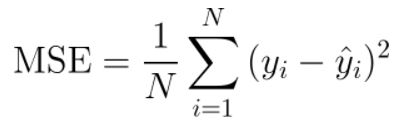


MAE(mean absolute error)는 평균 절대 오차라고도 불리며, 실제값과 예측값의 오차 절대값을 평균한 것이다.

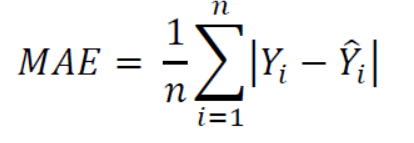

두 식의 결과가 모두 0에 가까울수록 모델의 예측 정밀도가 높음을 의미한다.

완전히 동일한 데이터 세트에 계산한 경우에만 상대적으로 크고 작음을 비교할 수 있다.



In [ ]:
# 컴파일
model.compile(loss='mse', optimizer=Adam(lr=0.001), metrics=['mae'])

# 학습
* EarlyStopping 준비

EarlyStopping는 지정된만큼 이폭을 반복하는 동안 개선이 없으면 학습을 중지하는 콜백이다. 콜백은 fit()에 인수를 지정해 1 이폭마다 임의의 처리를 실행하는 기능이다.

callbacks

EarlyStopping(monitor='val_loss', patience=0)

- 인수 : 
         monitor(str타입) 감시하는 값

         patience(int타입) 개선이 없으면 학습을 중지할 이폭 수


In [ ]:
# EarlyStopping 준비
early_stop = EarlyStopping(monitor='val_loss', patience=20)

In [ ]:
# 학습 실행
history = model.fit(train_data, train_labels, epochs=500,
                    validation_split=0.2, callbacks=[early_stop])

Epoch 1/500
11/11 [==============================] - 0s 11ms/step - loss: 6.0454 - mae: 1.7423 - val_loss: 6.9611 - val_mae: 2.0264
Epoch 2/500
11/11 [==============================] - 0s 6ms/step - loss: 6.1746 - mae: 1.7599 - val_loss: 6.7156 - val_mae: 1.9704
Epoch 3/500
11/11 [==============================] - 0s 7ms/step - loss: 6.1892 - mae: 1.7632 - val_loss: 7.4105 - val_mae: 2.1050
Epoch 4/500
11/11 [==============================] - 0s 7ms/step - loss: 5.8577 - mae: 1.7065 - val_loss: 6.7761 - val_mae: 1.9902
Epoch 5/500
11/11 [==============================] - 0s 6ms/step - loss: 5.8919 - mae: 1.6847 - val_loss: 7.3051 - val_mae: 2.0653
Epoch 6/500
11/11 [==============================] - 0s 6ms/step - loss: 5.9382 - mae: 1.7348 - val_loss: 7.3624 - val_mae: 2.1005
Epoch 7/500
11/11 [==============================] - 0s 5ms/step - loss: 5.8011 - mae: 1.7117 - val_loss: 6.8896 - val_mae: 2.0179
Epoch 8/500
11/11 [==============================] - 0s 6ms/step - loss: 5.8444 - 

학습 중 출력되는 정보

loss : 훈련 데이터 오차. 0에 가까울수록 좋다.

mean_absolute_error : 훈련 데이터 평균 절대 오차. 0에 가까울수록 좋다.

val_loss : 검증 데이터 오차. 0에 가까울수록 좋다.

val_mean_absolute_error : 검증 데이터 평균 절대 오차. 0에 가까울수록 좋다.

# 그래프 표시

fit()의 반환값 'history'에는 'loss'와 'val_loss'는 컴파일 시의 손실 함수, 그 이외에는 평가지표에서 지정한 것이다.

In [ ]:
print(history.history)

{'loss': [6.045417308807373, 6.174623966217041, 6.189233779907227, 5.857738494873047, 5.891939163208008, 5.9381537437438965, 5.801117420196533, 5.844412326812744, 5.827983379364014, 5.770547389984131, 5.80897855758667, 5.606435298919678, 5.742994785308838, 7.116840362548828, 5.937436103820801, 5.9638895988464355, 5.936316013336182, 6.4208245277404785, 5.751166343688965, 5.666335582733154, 5.516897678375244, 5.4822163581848145, 5.421261787414551, 5.366643905639648, 5.32990837097168, 5.277029514312744, 5.591243267059326, 5.445572853088379], 'mae': [1.7423135042190552, 1.759942650794983, 1.763150930404663, 1.7065013647079468, 1.6846843957901, 1.734823226928711, 1.711652159690857, 1.7054388523101807, 1.712091088294983, 1.6932531595230103, 1.7221959829330444, 1.6720293760299683, 1.6720255613327026, 1.9017086029052734, 1.7532784938812256, 1.7263942956924438, 1.7662382125854492, 1.8383046388626099, 1.7069324254989624, 1.7066363096237183, 1.6686478853225708, 1.6786295175552368, 1.6385195255279

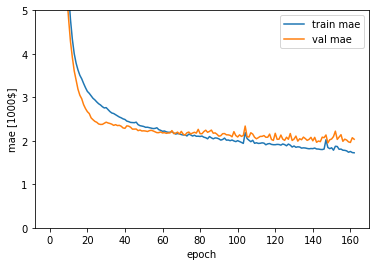

In [ ]:
# 위 정보를 matplotlib을 활용해 그래프로 표시
plt.plot(history.history['mae'], label='train mae')
plt.plot(history.history['val_mae'], label='val mae')
plt.xlabel('epoch')
plt.ylabel('mae [1000$]')
plt.legend(loc='best')
plt.ylim([0,5])
plt.show()

In [ ]:
# 평가
# 테스트 이미지와 테스트 라벨 배열을 모델에 전달해 평가를 실행하고, 평균 절대 오차를 얻는다.
test_loss, test_mae =model.evaluate(test_data,test_labels)
print('loss: {:.3f}\nmae:{:.3f}'.format(test_loss, test_mae))

4/4 [==============================] - 0s 2ms/step - loss: 16.2568 - mae: 2.6572
loss: 16.257
mae:2.657


# 추론
마지막으로 테스트 데이터 중 첫 10개로 추론을 수행해서 예측 결과를 얻는다. 

출력은 2차원 배열이므로 flatten()을 사용해 1차원 배열로 변환한 뒤 표시

실제 가격과 가까운 가격으로 추론하는지 볼 수 있다.

In [ ]:
# 실제 가격 표시
print(np.round(test_labels[0:10]))

# 추론한 가격 표시
test_predictions = model.predict(test_data[0:10]).flatten()
print(np.round(test_predictions))

[ 7. 19. 19. 27. 22. 24. 31. 23. 20. 23.]
[ 7. 20. 24. 32. 26. 23. 28. 22. 20. 21.]
